# Chanllenge description: 

Using the given dataset of transactions (notas fiscais eletrônicas) from a restaurant:
https://github.com/TOTVS/MDMStatic/blob/master/code-challenge/TOTVS%20Labs%20-%20AI%20Challenge%20-%20Dataset.zip?raw=true 

1. Parse and extract the data.
2. Identify a pattern on any set of fields that can help predict how much a customer will spend.
3. Calculate a sales forecast for the next week.

# 1. Parse and extract the data.

In [5]:
import json
import pandas as pd
import datetime
from flatten_json import flatten
from utils import print_pretty_json, pop_columns_which_name_contains    
    
# reading from json file to a dcitionary
data_dict = None
with open('data/sample.txt') as json_data:
    data_dict = json.load(json_data)

# add an id to each transaction
# cause if doesnt have a easy to spot one
for i in range(len(data_dict)):
    data_dict[i]['id'] = i
    
# print an example of a transtion
print_pretty_json(data_dict[0])


{
  "complemento": {
    "valorTotal": 24.9
  }, 
  "dets": [
    {
      "nItem": "1", 
      "prod": {
        "indTot": "1", 
        "qCom": 1.0, 
        "uCom": "UN", 
        "vProd": 3.5, 
        "vUnCom": 3.5, 
        "xProd": "AGUA"
      }
    }, 
    {
      "nItem": "2", 
      "prod": {
        "indTot": "1", 
        "qCom": 0.312, 
        "uCom": "KG", 
        "vProd": 21.4, 
        "vUnCom": 68.6, 
        "xProd": "BUFFET"
      }
    }
  ], 
  "emit": {
    "cnpj": "01.234.567/0001-89", 
    "enderEmit": {
      "fone": "1-650-933-4902", 
      "uf": "CA", 
      "xBairro": "", 
      "xLgr": "650 Castro St. unit 210", 
      "xMun": "Mountain View", 
      "xPais": "United States"
    }, 
    "xFant": "TOTVS Labs"
  }, 
  "id": 0, 
  "ide": {
    "dhEmi": {
      "$date": "2016-01-05T12:01:54.000Z"
    }, 
    "natOp": "VENDA"
  }, 
  "infAdic": {
    "infCpl": "Mesa 2"
  }, 
  "total": {
    "icmsTot": {
      "vDesc": 0.0, 
      "vFrete": 0.0, 
      "vOutro

### 1.1 Flattening the data


We can see that the key 'dets' has a list as value. This will make it complicated for us to turn it into data frame.


In [6]:
# trasnform to dataframe
data_transactions = pd.io.json.json_normalize(data_dict)

data_transactions.head(2)

,complemento.valorTotal,dets,emit.cnpj,emit.enderEmit.fone,emit.enderEmit.uf,emit.enderEmit.xBairro,emit.enderEmit.xLgr,emit.enderEmit.xMun,emit.enderEmit.xPais,emit.xFant,...,total.icmsTot.vcofins,total.icmsTot.vicms,total.icmsTot.vicmsDeson,total.icmsTot.vii,total.icmsTot.vipi,total.icmsTot.vnf,total.icmsTot.vpis,total.icmsTot.vst,versaoDocumento,versaoDocumento.$numberLong
0,24.90,"[{u'prod': {u'xProd': u'AGUA', u'vProd': 3.5, ...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,0.0,0.0,0.0,24.90,0.0,0.0,1.0,NaN
1,92.53,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 83....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,0.0,0.0,0.0,92.55,0.0,0.0,1.0,NaN


As we can see the column 'dets' did manage to normalize cause it can have more than one item. 
__We will pop this column out of this data_transactions.__

In [7]:
_ = data_transactions.pop(u'dets')

__And expand the data dictionary over each det__

In [8]:
data_dict_expanded = []
for transaction in data_dict:
    for det in transaction['dets']:
        # copy whole transaction
        data_dict_expanded.append(transaction.copy())
        # pop out the dets key and value
        data_dict_expanded[-1].pop('dets', None)
        # add the single det (flatten )
        data_dict_expanded[-1]['det'] = flatten(det, '.')
        # add a field with the total num of item of the order
        data_dict_expanded[-1]['num_items'] = len(transaction['dets'])

# print an example of the transctions expanded by each det
print_pretty_json(data_dict_expanded[0])

{
  "complemento": {
    "valorTotal": 24.9
  }, 
  "det": {
    "nItem": "1", 
    "prod.indTot": "1", 
    "prod.qCom": 1.0, 
    "prod.uCom": "UN", 
    "prod.vProd": 3.5, 
    "prod.vUnCom": 3.5, 
    "prod.xProd": "AGUA"
  }, 
  "emit": {
    "cnpj": "01.234.567/0001-89", 
    "enderEmit": {
      "fone": "1-650-933-4902", 
      "uf": "CA", 
      "xBairro": "", 
      "xLgr": "650 Castro St. unit 210", 
      "xMun": "Mountain View", 
      "xPais": "United States"
    }, 
    "xFant": "TOTVS Labs"
  }, 
  "id": 0, 
  "ide": {
    "dhEmi": {
      "$date": "2016-01-05T12:01:54.000Z"
    }, 
    "natOp": "VENDA"
  }, 
  "infAdic": {
    "infCpl": "Mesa 2"
  }, 
  "num_items": 2, 
  "total": {
    "icmsTot": {
      "vDesc": 0.0, 
      "vFrete": 0.0, 
      "vOutro": 0.0, 
      "vProd": 24.9, 
      "vSeg": 0.0, 
      "vTotTrib": 2.53, 
      "vbc": 0.0, 
      "vbcst": 0.0, 
      "vcofins": 0.0, 
      "vicms": 0.0, 
      "vicmsDeson": 0.0, 
      "vii": 0.0, 
      "vipi": 

In [9]:
# make it a data frame
data_dets = pd.io.json.json_normalize(data_dict_expanded)
# let's check the structure of the data now
data_dets.head(2)

,complemento.valorTotal,det.nItem,det.prod.indTot,det.prod.qCom,det.prod.uCom,det.prod.vProd,det.prod.vUnCom,det.prod.xProd,emit.cnpj,emit.enderEmit.fone,...,total.icmsTot.vcofins,total.icmsTot.vicms,total.icmsTot.vicmsDeson,total.icmsTot.vii,total.icmsTot.vipi,total.icmsTot.vnf,total.icmsTot.vpis,total.icmsTot.vst,versaoDocumento,versaoDocumento.$numberLong
0,24.9,1,1,1.000,UN,3.5,3.5,AGUA,01.234.567/0001-89,1-650-933-4902,...,0.0,0.0,0.0,0.0,0.0,24.9,0.0,0.0,1.0,NaN
1,24.9,2,1,0.312,KG,21.4,68.6,BUFFET,01.234.567/0001-89,1-650-933-4902,...,0.0,0.0,0.0,0.0,0.0,24.9,0.0,0.0,1.0,NaN


## 1.2 Parsing the columns to numeric and getting rid of unuseful colums

In [10]:
# let's check the info of the data
data_dets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 39 columns):
complemento.valorTotal         3547 non-null float64
det.nItem                      3547 non-null object
det.prod.indTot                3547 non-null object
det.prod.qCom                  3547 non-null float64
det.prod.uCom                  3547 non-null object
det.prod.vProd                 3547 non-null float64
det.prod.vUnCom                3547 non-null float64
det.prod.xProd                 3547 non-null object
emit.cnpj                      3547 non-null object
emit.enderEmit.fone            3547 non-null object
emit.enderEmit.uf              3547 non-null object
emit.enderEmit.xBairro         3547 non-null object
emit.enderEmit.xLgr            3547 non-null object
emit.enderEmit.xMun            3547 non-null object
emit.enderEmit.xPais           3547 non-null object
emit.xFant                     3547 non-null object
id                             3547 non-null int64
ide.dh

Transforming columns that are parsed as objects but should be numerical like det.nItem, det.prod.indTot.

In [11]:
# det.nItem to numeric
data_dets['det.nItem'] = pd.to_numeric(data_dets['det.nItem'], errors='coerce')
# det.prod.indTot to numeric
data_dets['det.prod.indTot'] = pd.to_numeric(data_dets['det.prod.indTot'], errors='coerce')

If we analyze the data from the location of the note, we'll realize __there is only one location__. Therefore is not relevant for our analysis.

In [12]:
data_dets['emit.enderEmit.xLgr'].describe()

count                        3547
unique                          1
top       650 Castro St. unit 210
freq                         3547
Name: emit.enderEmit.xLgr, dtype: object

We will remove the location emit.* columns out of our data

In [13]:
data_dets = pop_columns_which_name_contains(data_dets, 'emit.')
data_dets = pop_columns_which_name_contains(data_dets, 'total.')

We will parse ide.dhEmi.$date columns from string to datetime and split it into day information and time of the day, cause this way we can analisys this values independantly

In [14]:
# parsing ide.dhEmi.$date to datetime
data_dets['ide.dhEmi.$date'] = pd.to_datetime(data_dets['ide.dhEmi.$date'])

# add day column
data_dets['ide.dhEmi.$date.day'] = data_dets['ide.dhEmi.$date'].dt.date
data_dets['ide.dhEmi.$date.time'] = data_dets['ide.dhEmi.$date'].dt.time

data_dets['ide.dhEmi.$date.day'] = data_dets['ide.dhEmi.$date'].apply(lambda x: (x.date() - datetime.date(2000, 1, 1)).days)
data_dets['ide.dhEmi.$date.time'] = data_dets['ide.dhEmi.$date.time'].apply(lambda x: x.hour)
# pop out 'ide.dhEmi.$date'
_ = data_dets.pop('ide.dhEmi.$date')

# show some rows as example 
data_dets.loc[:,['ide.dhEmi.$date.day','ide.dhEmi.$date.time']].head(2)

,ide.dhEmi.$date.day,ide.dhEmi.$date.time
0,5848,12
1,5848,12


Checking which columns contain Nan

In [15]:
# check for each columns if it has more than one null value
pd.isnull(data_dets).sum() > 0

complemento.valorTotal         False
det.nItem                      False
det.prod.indTot                False
det.prod.qCom                  False
det.prod.uCom                  False
det.prod.vProd                 False
det.prod.vUnCom                False
det.prod.xProd                 False
id                             False
ide.natOp                      False
infAdic.infCpl                 False
num_items                      False
versaoDocumento                 True
versaoDocumento.$numberLong     True
ide.dhEmi.$date.day            False
ide.dhEmi.$date.time           False
dtype: bool

We can see that versaoDocumento, versaoDocumento.$numberLong both contain Nan. Let's analyze them, stating by versaoDocumento. 

In [16]:
data_dets['versaoDocumento'].value_counts()

1.0    2553
Name: versaoDocumento, dtype: int64

We can see that versaoDocumento only contains the value 1.0 and Nan. We can replace Nan for 0

In [17]:
data_dets['versaoDocumento'] = data_dets['versaoDocumento'].fillna(0)
data_dets['versaoDocumento'].value_counts()

1.0    2553
0.0     994
Name: versaoDocumento, dtype: int64

Now, let's do the same for versaoDocumento.$numberLong

In [18]:
data_dets['versaoDocumento.$numberLong'].value_counts()

1    994
Name: versaoDocumento.$numberLong, dtype: int64

In [19]:
data_dets['versaoDocumento.$numberLong'] = data_dets['versaoDocumento.$numberLong'].fillna(0)
data_dets['versaoDocumento.$numberLong'].value_counts()

0    2553
1     994
Name: versaoDocumento.$numberLong, dtype: int64

They seem to contain the same info versaoDocumento, versaoDocumento that is missing in the other one. This is cause by a variation in the structure of the json file. In any case it only contains the value 1.0. So, it is not valuebale data for the analysis so will pop them out. 

In [20]:
data_dets = pop_columns_which_name_contains(data_dets, 'versaoDocumento.')

Lets analyse the case of ide.natOp

In [21]:
data_dets['ide.natOp'].value_counts()

VENDA    3547
Name: ide.natOp, dtype: int64

Because there is only one value, we can pop this column too.

In [22]:
_ = data_dets.pop('ide.natOp')

Handeling categorical columns like det.prod.uCom, det.prod.xProd. We will add an encoded column for each one

In [23]:
from sklearn.preprocessing import LabelEncoder

# create label encoders
det_prod_uCom_encoder = LabelEncoder()
det_prod_xProd_encoder = LabelEncoder()
infAdic_infCpl_encoder = LabelEncoder()

# create encoded columns
data_dets['det.prod.uCom_encoded'] = det_prod_uCom_encoder.fit_transform(data_dets['det.prod.uCom'])
data_dets['det.prod.xProd_encoded'] = det_prod_xProd_encoder.fit_transform(data_dets['det.prod.xProd'])
data_dets['infAdic.infCpl_encoded'] = infAdic_infCpl_encoder.fit_transform(data_dets['infAdic.infCpl'])

# check some examples
data_dets.loc[:3,['det.prod.uCom','det.prod.uCom_encoded','det.prod.xProd','det.prod.xProd_encoded', 'infAdic.infCpl', 'infAdic.infCpl_encoded']]

,det.prod.uCom,det.prod.uCom_encoded,det.prod.xProd,det.prod.xProd_encoded,infAdic.infCpl,infAdic.infCpl_encoded
0,UN,1,AGUA,0,Mesa 2,10
1,KG,0,BUFFET,2,Mesa 2,10
2,KG,0,BUFFET,2,Mesa 1,0
3,UN,1,REFRIGERANTE,13,Mesa 1,0


Pop out this categorical value (just keep the numerical values) 

In [24]:
_ = data_dets.pop('det.prod.uCom')
_ = data_dets.pop('det.prod.xProd')
_ = data_dets.pop('infAdic.infCpl')
_ = data_dets.pop('id')
_ = data_dets.pop('num_items')
_ = data_dets.pop('det.nItem')

In [25]:
print data_dets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
complemento.valorTotal    3547 non-null float64
det.prod.indTot           3547 non-null int64
det.prod.qCom             3547 non-null float64
det.prod.vProd            3547 non-null float64
det.prod.vUnCom           3547 non-null float64
versaoDocumento           3547 non-null float64
ide.dhEmi.$date.day       3547 non-null int64
ide.dhEmi.$date.time      3547 non-null int64
det.prod.uCom_encoded     3547 non-null int64
det.prod.xProd_encoded    3547 non-null int64
infAdic.infCpl_encoded    3547 non-null int64
dtypes: float64(5), int64(6)
memory usage: 304.9 KB
None


In [26]:
data_dets.head()

,complemento.valorTotal,det.prod.indTot,det.prod.qCom,det.prod.vProd,det.prod.vUnCom,versaoDocumento,ide.dhEmi.$date.day,ide.dhEmi.$date.time,det.prod.uCom_encoded,det.prod.xProd_encoded,infAdic.infCpl_encoded
0,24.90,1,1.000,3.50,3.5,1.0,5848,12,1,0,10
1,24.90,1,0.312,21.40,68.6,1.0,5848,12,0,2,10
2,92.53,1,1.218,83.55,68.6,1.0,5848,12,0,2,0
3,92.53,1,2.000,9.00,4.5,1.0,5848,12,1,13,0
4,57.86,1,1.000,4.50,4.5,1.0,5848,12,1,17,35


# 2. Analize features that influence the value

In [27]:
y = data_dets.pop('complemento.valorTotal')

In [28]:
X = data_dets.values
print 'labels:',y.values
X[0]

labels: [ 24.9   24.9   92.53 ... 102.09  32.8   32.8 ]


array([1.000e+00, 1.000e+00, 3.500e+00, 3.500e+00, 1.000e+00, 5.848e+03,
       1.200e+01, 1.000e+00, 0.000e+00, 1.000e+01])

In [29]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

regr = RandomForestRegressor(n_estimators=2000, max_depth=2, random_state=0)
regr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [30]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("feature %d: %s has importance=%f" % (indices[f], data_dets.columns[indices[f]], importances[indices[f]]))

Feature ranking:
feature 1: det.prod.qCom has importance=0.758239
feature 6: ide.dhEmi.$date.time has importance=0.218282
feature 2: det.prod.vProd has importance=0.022267
feature 8: det.prod.xProd_encoded has importance=0.001212
feature 9: infAdic.infCpl_encoded has importance=0.000000
feature 7: det.prod.uCom_encoded has importance=0.000000
feature 5: ide.dhEmi.$date.day has importance=0.000000
feature 4: versaoDocumento has importance=0.000000
feature 3: det.prod.vUnCom has importance=0.000000
feature 0: det.prod.indTot has importance=0.000000


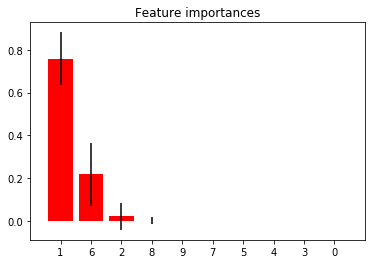

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## 3. Forcasting the revenue of the next week

We will use [Prophet](https://facebook.github.io/prophet/) library from facebook. Tha is a great tool for time series forcasting. It is based on an additive model where non-linear trends are fit with seasonalities. 

In [32]:
# We will use Prophet library from facebook. Tha is a great tool for time series forcasting
from fbprophet import Prophet

We will create a new dataframe __df__ that only containes the date of the transcation and the value of it.

In [33]:
# define a new dataframe that only containes the date of the transcation and the value
df = data_transactions.loc[:, ['ide.dhEmi.$date', 'complemento.valorTotal']]
print df.head()

            ide.dhEmi.$date  complemento.valorTotal
0  2016-01-05T12:01:54.000Z                   24.90
1  2016-01-05T12:03:52.000Z                   92.53
2  2016-01-05T12:16:40.000Z                   57.86
3  2016-01-05T12:17:50.000Z                   34.97
4  2016-01-05T12:18:35.000Z                   46.23


We will reduce the datetime to the hour value.

In [34]:
# turn date as string into timestamp
df['ide.dhEmi.$date'] = pd.to_datetime(df['ide.dhEmi.$date'])
# reduce timestamps to the hour value
df['ide.dhEmi.$date'] = df['ide.dhEmi.$date'].apply( lambda t : datetime.datetime(year=t.year, month=t.month, day=t.day, hour=t.hour))
print df.head()

      ide.dhEmi.$date  complemento.valorTotal
0 2016-01-05 12:00:00                   24.90
1 2016-01-05 12:00:00                   92.53
2 2016-01-05 12:00:00                   57.86
3 2016-01-05 12:00:00                   34.97
4 2016-01-05 12:00:00                   46.23


We will group and sum all the transaction for the same datetime (at hour level).

In [35]:
df = df.groupby(['ide.dhEmi.$date'], as_index=False).sum()
print df.head()

      ide.dhEmi.$date  complemento.valorTotal
0 2016-01-05 12:00:00                 1129.37
1 2016-01-05 13:00:00                 1452.09
2 2016-01-05 14:00:00                  236.43
3 2016-01-05 18:00:00                  105.63
4 2016-01-05 19:00:00                  295.85


And rename the columns to macth Prophet's requirement: The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column must contain a date or datetime (either is fine). The y column must be numeric, and represents the measurement we wish to forecast.

In [36]:
# rename and set ds as index
df = df.rename(columns={'ide.dhEmi.$date':'ds','complemento.valorTotal': 'y'})
df = df.set_index('ds')

# add the missing values with a zero value
df = df.resample('1H').sum()
df['y'] = df['y'].fillna(0)

print df.tail()

                           y
ds                          
2016-01-23 10:00:00     0.00
2016-01-23 11:00:00   140.89
2016-01-23 12:00:00   955.46
2016-01-23 13:00:00  1651.95
2016-01-23 14:00:00  1205.21


Let's plot it

(array([735969., 735971., 735973., 735975., 735977., 735979., 735981.,
        735983., 735985., 735987.]), <a list of 10 Text xticklabel objects>)

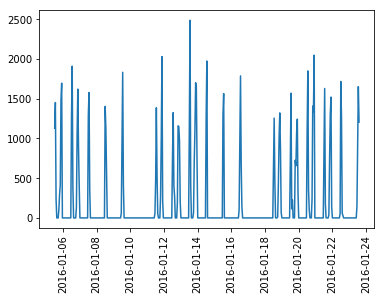

In [37]:
plt.plot(df)
plt.xticks(rotation='vertical')

Now we will instanciate our prophet model

In [44]:
my_model = Prophet(changepoint_prior_scale=0.01)

and fit it with our dataframe df

In [45]:
df['ds'] = df.index
my_model.fit(df)

Let's create the dataframe with the future dates we want to forcast. This means 7 days * 24 hours extra datepoints.

In [46]:
future_dates = my_model.make_future_dataframe(periods=7*24, freq='h')
future_dates.tail(3)

,ds
600,2016-01-30 12:00:00
601,2016-01-30 13:00:00
602,2016-01-30 14:00:00


Let's create our forecast and analize our prediction components.

In [48]:
forecast = my_model.predict(future_dates)
forecast.tail(3)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
600,2016-01-30 12:00:00,218.994769,218.990872,218.998795,376.092015,1186.230543,590.801343,590.801343,590.801343,573.607802,573.607802,573.607802,573.607802,573.607802,573.607802,-17.193541,-17.193541,-17.193541,792.602571
601,2016-01-30 13:00:00,219.061995,219.058048,219.066054,499.683354,1335.940043,731.111739,731.111739,731.111739,708.346685,708.346685,708.346685,708.346685,708.346685,708.346685,-22.765054,-22.765054,-22.765054,927.408679
602,2016-01-30 14:00:00,219.129220,219.125227,219.133322,282.760114,1119.692952,513.623238,513.623238,513.623238,484.412464,484.412464,484.412464,484.412464,484.412464,484.412464,-29.210774,-29.210774,-29.210774,703.541684


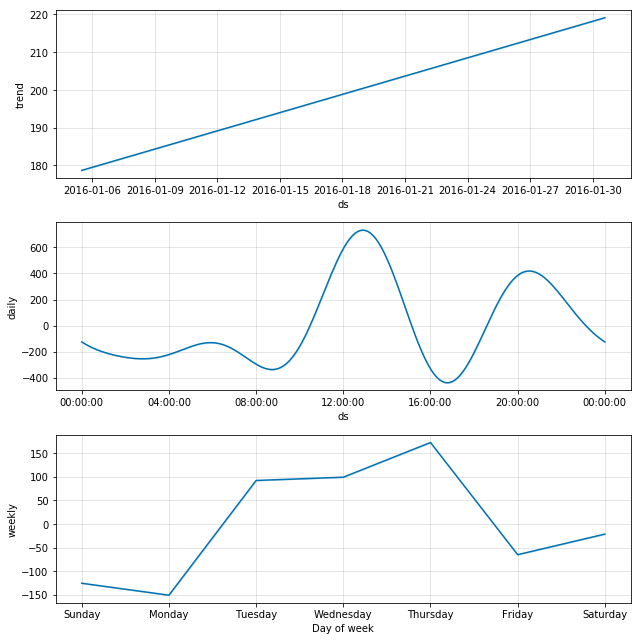

In [49]:
my_model.plot_components(forecast);

Let's calculate the prediction for the next week (next 7*24 hours) from __2016-01-23 15:00__ to __2016-01-30 14:00__

In [42]:
##### get the last 7*24 points
next_week = forecast.loc[:,['ds', 'yhat']].tail(7*24)
# sum up all the values
next_week_forecast = next_week['yhat'].sum()
print ("Next week sales forcast = {}".format(next_week_forecast))

Next week sales forcast = 35870.6734192
